In [ ]:
import yfinance as yf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import ta
from keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# # 2단계: fine-tuning (최근 2년치, 테스트셋이던 X_test, y_test로 학습)
# # learning rate를 작게 설정해서 기존 학습 내용 보존하며 업데이트
# fine_tune_lr = 1e-4
# model.compile(optimizer=Adam(learning_rate=fine_tune_lr), loss='mse')

# # 주의: 검증 데이터(validation_split)는 사용하지 않음 (이미 평가된 데이터니까)
# model.fit(X_test, y_test, epochs=10, batch_size=32, verbose=1)

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\Users\pyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0408 - val_loss: 0.0022
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052 - val_loss: 6.8279e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 7.1781e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0040 - val_loss: 5.7287e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 5.7183e-04
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 4.9727e-04
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 4.3109e-04
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/ste

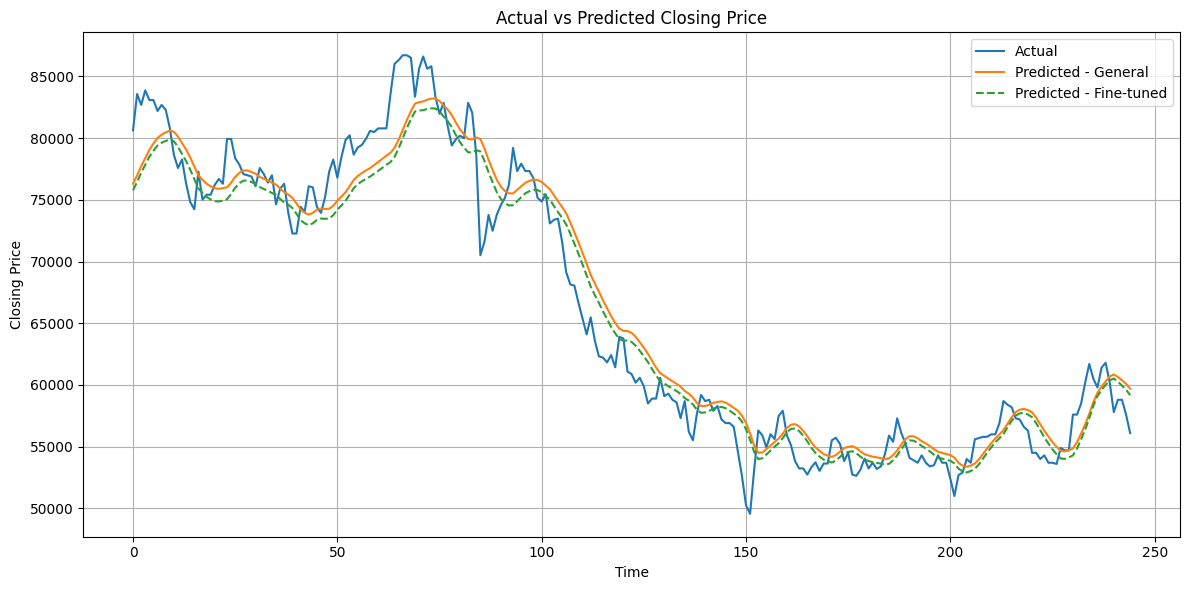

가장 최근 실제 종가: 56100.00
일반 모델 예측 종가: 59698.92
파인튜닝 모델 예측 종가: 59172.42


In [12]:
from keras.models import clone_model

# 1. 데이터 다운로드
# 1. 데이터 다운로드 (OHLCV 자동 포함)
df = yf.download('005930.KS', start='2015-01-01', end='2025-04-05')
# 2. 기술적 지표 추가 (1차원 시리즈로 변환하여 계산)
close_prices = df['Close'].squeeze()  # 1차원 보장
# 이동평균 (MA20)
df['MA20'] = trend.sma_indicator(close_prices, window=20)
# 볼린저 밴드 (상한/하한)
bb = volatility.BollingerBands(close_prices, window=20, window_dev=2)
df['Upper'] = bb.bollinger_hband()
df['Lower'] = bb.bollinger_lband()
# RSI (14일 기준)
df['RSI'] = momentum.rsi(close_prices, window=14)
# 결측치 제거
df.dropna(inplace=True)


# 2. 정규화 및 데이터 준비
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'Upper', 'Lower', 'RSI']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

sequence_length = 50
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length][features.index('Close')])
X, y = np.array(X), np.array(y)

# 3. 데이터 분할 (70/20/10)
total_len = len(X)
train_end = int(0.7 * total_len)
val_end = int(0.9 * total_len)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# 4. 일반 모델 학습
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32,
          validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# 5. 일반 모델 평가
pred = model.predict(X_test)

# 6. 파인튜닝 모델 복제 후 학습
model_ft = clone_model(model)
model_ft.set_weights(model.get_weights())
model_ft.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model_ft.fit(X_val, y_val, epochs=10, batch_size=32, verbose=1)

# 7. 파인튜닝 모델 평가
pred_ft = model_ft.predict(X_test)

# 8. 역변환 함수 정의
close_index = features.index('Close')
def inverse_transform_close(scaled_vals):
    dummy = np.zeros((len(scaled_vals), len(features)))
    dummy[:, close_index] = scaled_vals.flatten()
    return scaler.inverse_transform(dummy)[:, close_index]

true_rescaled = inverse_transform_close(y_test)
pred_rescaled = inverse_transform_close(pred)
pred_ft_rescaled = inverse_transform_close(pred_ft)

# 9. 평가 지표

def smape(a, f):
    return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

def evaluate(name, true, pred):
    print(f"[{name} Model]")
    print(f"MSE: {mean_squared_error(true, pred):.2f}")
    print(f"MAE: {mean_absolute_error(true, pred):.2f}")
    print(f"sMAPE: {smape(true, pred):.2f}%\n")

evaluate("General", true_rescaled, pred_rescaled)
evaluate("Fine-tuned", true_rescaled, pred_ft_rescaled)

# 10. 시각화
plt.figure(figsize=(12, 6))
plt.plot(true_rescaled, label='Actual')
plt.plot(pred_rescaled, label='Predicted - General')
plt.plot(pred_ft_rescaled, label='Predicted - Fine-tuned', linestyle='--')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. 가장 최근 예측
print(f"가장 최근 실제 종가: {true_rescaled[-1]:.2f}")
print(f"일반 모델 예측 종가: {pred_rescaled[-1]:.2f}")
print(f"파인튜닝 모델 예측 종가: {pred_ft_rescaled[-1]:.2f}")


In [13]:
ticker = yf.Ticker('AAPL')
df_full = ticker.history(period='max')
print(df_full.index[0])  # 최초 데이터 날짜 (상장일 또는 데이터 시작일)
print(df_full.index[-1])  # 최신 데이터 날짜

1980-12-12 00:00:00-05:00
2025-04-29 00:00:00-04:00
